In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import gym
import mo_gym
import safe_grid_gym

from pymove.tabular_q_learning import TabularQLearning, TabularQLambda
from pymove.scalarizations import WeightedScalarization, ELA, SFLLA, vELA, vSFLLA
from pymove.order_operators import ScalarizingOrderOperator, LexicographicOrderOperator
from pymove.exploration import SoftmaxExploration, EpsilonGreedy

import time

In [7]:
env = gym.make("IslandNavigationEx-v0", level=4)
env.num_objectives = len(env.env._env.__dict__["enabled_mo_reward_dimensions"])
#env.num_objectives = np.prod(env.reward_space.shape)
print(np.array(env.observation_space.shape[1:]))
#env.reset()

[6 8]


In [55]:
env.num_actions = env.action_space.n
env.num_observations = np.prod(np.array(env.observation_space.shape[1:]))
print(env.num_observations)
def get_obs_idx(obs):
    agent_pos = np.where(obs[0,:,:] == 2.)
    multi_index = np.array([[agent_pos[0][0]], [agent_pos[1][0]]])
    return np.ravel_multi_index(multi_index, env.observation_space.shape[1:])
env.get_obs_idx = get_obs_idx

15


In [56]:

# parameters
num_episodes = 100
eps = 0.05
eps_decay = 0.995

# Linear
#lin_expp = SoftmaxExploration(env, ranking_method="tournament")
lin_expp = EpsilonGreedy(env, epsilon=eps, decay_type="exp", decay_params={"decay_rate": eps_decay})
tq_algo_lin = TabularQLearning(env, num_episodes=num_episodes, exploration_policy=lin_expp)

# LIN Q(lambda)
lin_expp2 = EpsilonGreedy(env, epsilon=eps, decay_type="exp", decay_params={"decay_rate": eps_decay})
tql_algo_lin = TabularQLambda(env, num_episodes=num_episodes, exploration_policy=lin_expp2)

# LO
LO_op = LexicographicOrderOperator(objective_order=[0, 1])
LO_expp = EpsilonGreedy(env, epsilon=0.1, decay_params={"decay_rate": 0.9999}, order_operation=LO_op)
tq_algo_lo = TabularQLearning(env, alpha=0.01, num_episodes=num_episodes, exploration_policy=LO_expp)


In [57]:
algo_dict = {
        "Linear, tabular Q": tq_algo_lin,
        #"Linear, tabular Q(Lambda)": tql_algo_lin,
        #"LO, tabular Q": tq_algo_lo
        }

# learning
for (label, algo) in algo_dict.items():
    t_start = time.time()
    algo.learn()
    print(f"Finished {label} in {time.time() - t_start:.2f}s")
    print(f"Mean returns: {algo.returns.mean(axis=1)}")


Finished Linear, tabular Q in 16.43s
Mean returns: [-9.994e+01 -5.050e+03  0.000e+00 -1.200e-01  1.999e+03]


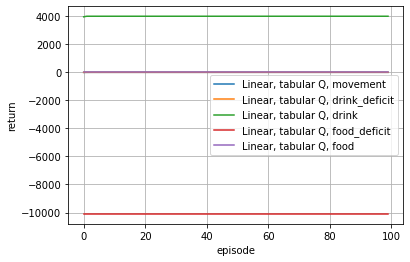

In [54]:
# plotting
plt.figure()
for (label, algo) in algo_dict.items():
    plt.plot(algo.returns[0, :], label=label+", movement")
    plt.plot(algo.returns[1, :], label=label+", drink_deficit")
    plt.plot(algo.returns[2, :], label=label+", drink")
    plt.plot(algo.returns[3, :], label=label+", food_deficit")
    plt.plot(algo.returns[4, :], label=label+", food")
plt.xlabel("episode")
plt.ylabel("return")
plt.grid()
plt.legend()
plt.show()

In [51]:
env.env._env.__dict__["enabled_mo_reward_dimensions"]

[<{'MOVEMENT_REWARD': -1}>,
 <{'DRINK_DEFICIENCY_REWARD': -1}>,
 <{'DRINK_REWARD': 20}>,
 <{'FOOD_DEFICIENCY_REWARD': -1}>,
 <{'FOOD_REWARD': 20}>]